In [ ]:
import csv
import cv2
import numpy as np

lines = []
with open("../sdc_training_data/driving_log.csv") as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)
        
images = []
measurements = []
for line in lines:
    sourcepath = line[0]
    filename = sourcepath.split('/')[-1]
    currentpath = '../sdc_training_data/IMG/' + filename
    image = cv2.imread(currentpath)
    images.append(image)
    
    measurement = float(line[3])
    measurements.append(measurement)
    
augmeted_images, augmeted_measurements = [], []
for image, measurement in zip(images, measurements):
    augmeted_images.append(cv2.flip(image, 1))
    augmeted_measurements.append(-measurement)
    augmeted_images.append(image)
    augmeted_measurements.append(measurement)
    
X_train = np.array(augmeted_images)
y_train = np.array(augmeted_measurements)

import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Input, Convolution2D, MaxPooling2D, Flatten, Dense, Lambda
from keras.layers import Cropping2D


model = Sequential()
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))

# LeNet model
# model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))
# model.add(Convolution2D(6,5,5, activation="relu"))
# model.add(MaxPooling2D())
# model.add(Convolution2D(6,5,5, activation="relu"))
# model.add(MaxPooling2D())
# model.add(Flatten())
# model.add(Dense(120))
# model.add(Dropout(0.2))
# model.add(Dense(84))
# model.add(Dropout(0.2))
# model.add(Dense(1))

# Nvidia model
model.add(Cropping2D(cropping=((70,25), (0,0)), input_shape=(160,320,3)))
model.add(Convolution2D(24,5,5, subsample=(2,2), activation="relu"))
model.add(Convolution2D(36,5,5, subsample=(2,2), activation="relu"))
model.add(Convolution2D(48,5,5, subsample=(2,2), activation="relu"))
model.add(Convolution2D(64,3,3, activation="relu"))
model.add(Convolution2D(64,3,3, activation="relu"))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss="mse", optimizer="adam")
history_object = model.fit(X_train, y_train, validation_split=0.3, shuffle=True, nb_epoch=5, verbose=1)
model.save("model.h5")


dict_keys(['loss', 'val_loss'])


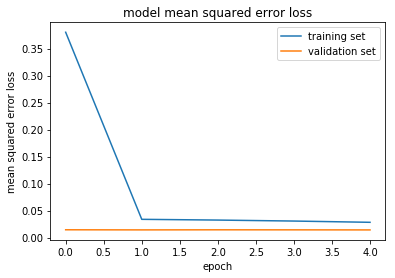

In [3]:
import matplotlib.pyplot as plt

print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

print(history_object.history.keys())